In [118]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore"
                         )
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [119]:
# Use the correct path for the dataset directory
data = '/Users/irk2w/Desktop/T5/CUSTOM_DATASET/'

# Now use os.listdir to read the contents of the directory
dir_list = os.listdir(dataset_directory)
dir_list.sort()

emotion = []
path = []
for i in dir_list:
    # Make sure to join the directory path and the subdirectory/file name
    sub_dir_path = os.path.join(dataset_directory, i)
    # Check if it's a directory before attempting to list its contents
    if os.path.isdir(sub_dir_path):
        fname = os.listdir(sub_dir_path)
        for f in fname:
            # Skip system files or any files that don't match your expected format
            if f.endswith('.wav'):  # Assuming your files are .wav audio files
                part = f.split('.')[0].split('_')
                emotion.append(int(part[0]))
                file_path = os.path.join(sub_dir_path, f)
                path.append(file_path)

In [120]:
def text_num_split(item):
    for index, letter in enumerate(item, 0):
        if letter.isdigit():
            return [item[:index],item[index:]]

In [121]:
dir_list = os.listdir(data)
dir_list.sort()

emotion = []
path = []
for i in dir_list:
    fname = os.listdir(data + i)
    for f in fname:
        part = f.split('.')[0].split('_')
        emotion.append(int(part[0]))
        path.append(data + i + '/' + f)

In [122]:
df = pd.DataFrame(emotion)
map_dict = {1:'angry', 2:'drunk', 3:'painful', 4:'stressful'}
df.columns = ['Emotion']
df["Emotion"] = df['Emotion'].map(map_dict)
df = pd.concat([df,pd.DataFrame(path, columns = ['path'])],axis=1)
df.Emotion.value_counts()

Emotion
stressful    87
angry        87
painful      86
drunk        78
Name: count, dtype: int64

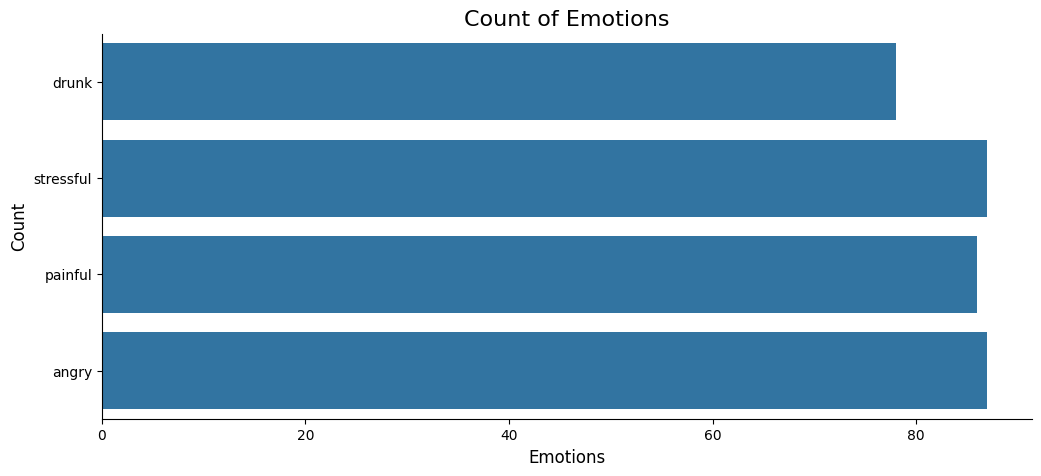

In [123]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(df.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [124]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [125]:
# Trying different functions above
path = np.array(df['path'])[217]
data, sample_rate = librosa.load(path)

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

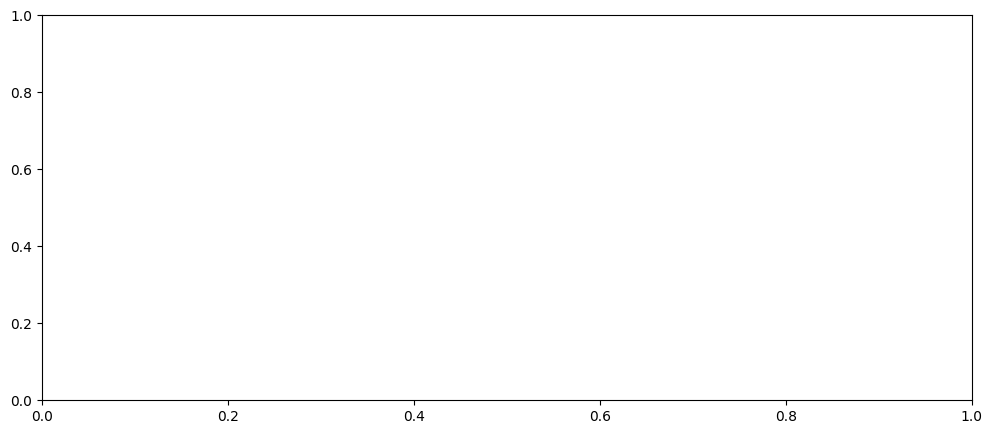

In [126]:
# NORMAL AUDIO
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

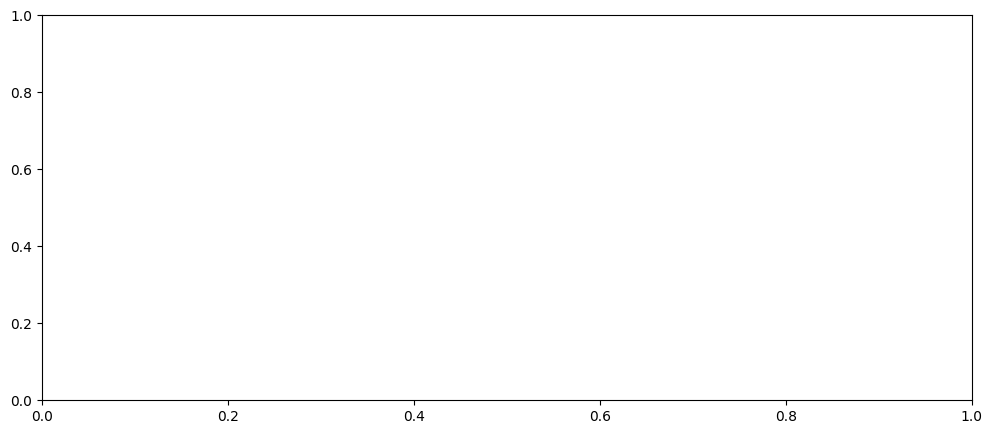

In [127]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [128]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

TypeError: time_stretch() takes 1 positional argument but 2 were given

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

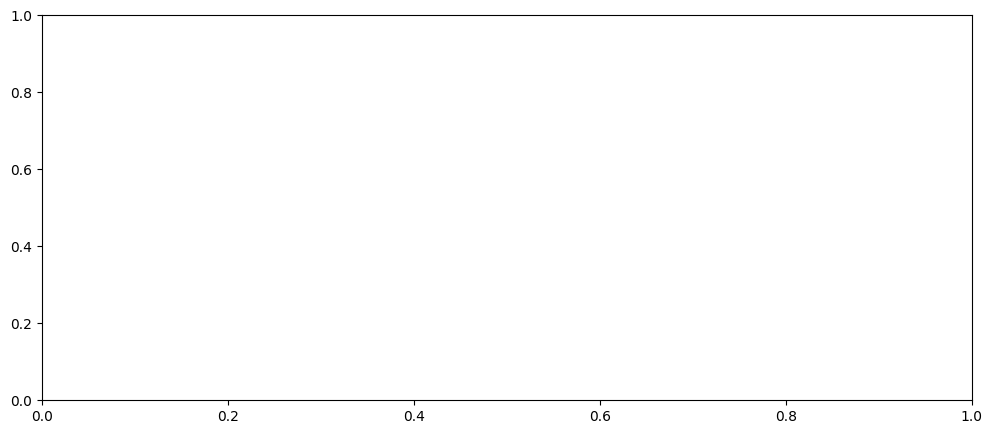

In [130]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [131]:
# AUDIO WITH PITCH
x = pitch(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

TypeError: pitch_shift() takes 1 positional argument but 3 were given

In [70]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [71]:
df.head()
df['path'][0]

'/Users/irk2w/Desktop/T5/CUSTOM_DATASET/Speaker1/02_03_01_01_01.wav'

In [72]:
X, Y = [], []
for path, emotion in zip(df['path'], df['Emotion']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

TypeError: time_stretch() takes 1 positional argument but 2 were given

In [73]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,labels


In [74]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [75]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [76]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [77]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=3)
clf1.fit(x_train,y_train)

NameError: name 'x_train' is not defined

In [78]:
y_pred=clf1.predict(x_test)

NameError: name 'x_test' is not defined

In [79]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

NameError: name 'x_train' is not defined

In [80]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier(n_estimators=25,objective="binary:logistic", colsample_bytree=0.8,max_depth=5,reg_lambda= 7,scale_pos_weight=3, subsample=1)

xgb_cl

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [81]:
xgb_cl.fit(x_train,y_train)

y_pred=xgb_cl.predict(x_test)
print("Training set score: {:.3f}".format(xgb_cl.score(x_train, y_train)))
print("Test set score: {:.3f}".format(xgb_cl.score(x_test, y_test)))

NameError: name 'x_train' is not defined

In [82]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

NameError: name 'x_train' is not defined

In [83]:
y_pred=clf2.predict(x_test)

NameError: name 'x_test' is not defined

In [84]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

NameError: name 'x_train' is not defined

In [85]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

NameError: name 'x_train' is not defined

In [86]:
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

NameError: name 'x_train' is not defined

In [87]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=1500, validation_data=(x_testcnn, y_test))

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

In [ ]:
epochs = [i for i in range(1500)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(100)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
model_name = 'Emotion_Emergency.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/saved_models/Emotion_Emergency.h5")
print("Loaded model from disk")

In [ ]:
data, sampling_rate = librosa.load('../input/dataset-ec/RAW_DATA/NOT_STRESSFUL/not_stressful61.wav')

In [ ]:
sample = "../input/customdata/CUSTOM_DATASET/Speaker3/02_03_01_01_03.wav"
feature = get_feat(sample)
test =np.expand_dims(feature, axis=2)
livepreds = loaded_model.predict(test)
livepredictions = (encoder.inverse_transform((livepreds)))
livepredictions